In [2]:
from google.colab import drive
drive.mount('/content/drive')
import tqdm
from tqdm import tqdm
tqdm.pandas()

Mounted at /content/drive


In [3]:
!pip install imbalanced-learn

In [4]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.2 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=ada0e606afea07aa3d2dc0af0fd6a2a4ad568f74408f65e5e8731cdbb104b004
  Stored in directory: /root/.cache

In [5]:
!pip install transformers sentence-transformers scikit-learn

In [6]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.8 MB/s eta 0:00:00


In [7]:
import pandas as pd

In [ ]:
from flair.data import Sentence
from flair.nn import Classifier

tagger = Classifier.load("hunflair2")

train_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_val.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_test.csv')


def extract_entities(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    entities = [(entity.text, entity.tag) for entity in sentence.get_spans('ner')]
    return entities

train_df['entities'] = train_df['text'].progress_apply(extract_entities)
test_df['entities'] = test_df['text'].progress_apply(extract_entities)
val_df['entities'] = val_df['text'].progress_apply(extract_entities)

train_df.to_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_train_disease_entities.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_val_disease_entities.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_test_disease_entities.csv', index=False)

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_train_disease_entities.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_test_disease_entities.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ML Final Project/cohort/los/admission_only_true/LOS_WEEKS_adm_val_disease_entities.csv')

In [9]:
import ast

train_df['entities'] = train_df['entities'].apply(ast.literal_eval)
test_df['entities'] = test_df['entities'].apply(ast.literal_eval)
val_df['entities'] = val_df['entities'].apply(ast.literal_eval)

In [10]:
from collections import defaultdict

disease_freq = defaultdict(int)
entities_list = train_df['entities'].tolist()
for entities in tqdm(entities_list):
    for entity_text, entity_tag in entities:
        if entity_tag == "Disease":
            disease_freq[entity_text] += 1


sorted_disease_freq = dict(sorted(disease_freq.items(), key=lambda item: item[1], reverse=True))

100%|██████████| 30421/30421 [00:00<00:00, 42527.44it/s]


In [11]:
len(sorted_disease_freq)

47964

In [12]:
train_df['diseases_only'] = train_df['entities'].apply(
    lambda entities: [entity[0] for entity in entities if entity[1] == 'Disease']
)
test_df['diseases_only'] = test_df['entities'].apply(
    lambda entities: [entity[0] for entity in entities if entity[1] == 'Disease']
)
val_df['diseases_only'] = val_df['entities'].apply(
    lambda entities: [entity[0] for entity in entities if entity[1] == 'Disease']
)

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


model.eval()
model = model.to('cuda')

def generate_embeddings(texts, batch_size=32):
    embeddings = []
    dataloader = DataLoader(texts, batch_size=batch_size, shuffle=False)

    for batch in tqdm(dataloader, desc="Generating embeddings"):
        tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to('cuda')
        with torch.no_grad():
            output = model(**tokens)

        batch_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)

    return embeddings

disease_names = list(disease_freq.keys())

batch_size = 64
embeddings = generate_embeddings(disease_names, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 750/750 [00:37<00:00, 19.84it/s]


In [14]:
import faiss
import numpy as np
from tqdm.notebook import tqdm

embeddings_array = np.array(embeddings).astype('float32')
print(len(embeddings_array))

num_clusters = 256

embedding_dim = embeddings_array.shape[1]

res = faiss.StandardGpuResources()
faiss_index = faiss.IndexFlatL2(embedding_dim)
gpu_index = faiss.index_cpu_to_gpu(res, 0, faiss_index)

kmeans = faiss.Clustering(embedding_dim, num_clusters)
kmeans.niter = 200
kmeans.max_points_per_centroid = 50000

kmeans.train(embeddings_array, gpu_index)

centroids = faiss.vector_to_array(kmeans.centroids).reshape(num_clusters, embedding_dim)
_, cluster_ids = gpu_index.search(embeddings_array, 1)
cluster_ids = cluster_ids.flatten()

47964


In [15]:

word_to_cluster = {disease_names[i]: int(cluster_ids[i]) for i in range(len(disease_names))}


In [16]:

train_df['cluster_ids'] = train_df['diseases_only'].apply(lambda diseases: [word_to_cluster.get(disease) for disease in diseases])


In [17]:

def assign_clusters(diseases, word_to_cluster):
    return [word_to_cluster.get(disease, -1) for disease in diseases if disease in word_to_cluster]

test_df['cluster_ids'] = test_df['diseases_only'].apply(lambda diseases: assign_clusters(diseases, word_to_cluster))
val_df['cluster_ids'] = val_df['diseases_only'].apply(lambda diseases: assign_clusters(diseases, word_to_cluster))


In [18]:
import numpy as np

num_clusters = 256

def create_one_hot_vector(diseases, word_to_cluster, num_clusters):
    one_hot = np.zeros(num_clusters, dtype=int)
    for disease in diseases:
        cluster_id = word_to_cluster.get(disease, -1)
        if cluster_id != -1:
            one_hot[cluster_id] = 1
    return one_hot

train_df['one_hot_features'] = train_df['diseases_only'].apply(
    lambda diseases: create_one_hot_vector(diseases, word_to_cluster, num_clusters)
)

X = np.stack(train_df['one_hot_features'].values)

print(f"Feature matrix shape: {X.shape}")
print(f"Sample feature vector: {X[0]}")


Feature matrix shape: (30421, 256)
Sample feature vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [19]:
def create_one_hot_vector(cluster_ids, num_clusters):
    one_hot = np.zeros(num_clusters, dtype=int)
    for cluster_id in cluster_ids:
        if cluster_id != -1:
            one_hot[cluster_id] = 1
    return one_hot

num_clusters = 256


test_df['one_hot_features'] = test_df['cluster_ids'].apply(lambda clusters: create_one_hot_vector(clusters, num_clusters))
val_df['one_hot_features'] = val_df['cluster_ids'].apply(lambda clusters: create_one_hot_vector(clusters, num_clusters))


X_test = np.stack(test_df['one_hot_features'].values)
X_val = np.stack(val_df['one_hot_features'].values)
y_test = test_df['los_label'].values
y_val = val_df['los_label'].values


In [ ]:
import xgboost as xgb

y = train_df['los_label'].values

dtrain = xgb.DMatrix(X, label=y)
params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

model = xgb.train(params, dtrain, num_boost_round=100)

In [30]:
X.shape

(30421, 256)

In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

y_pred = model.predict(dtest)
y_pred = np.argmax(y_pred, axis=1)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.3803569398658634
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.09      0.14      1121
           1       0.41      0.67      0.50      3328
           2       0.35      0.29      0.32      2692
           3       0.32      0.14      0.20      1656

    accuracy                           0.38      8797
   macro avg       0.34      0.30      0.29      8797
weighted avg       0.36      0.38      0.34      8797



In [ ]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)


logreg.fit(X, y)


y_pred = logreg.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.3791065135841764
              precision    recall  f1-score   support

           0       0.24      0.02      0.04      1121
           1       0.39      0.81      0.52      3328
           2       0.35      0.19      0.25      2692
           3       0.34      0.07      0.12      1656

    accuracy                           0.38      8797
   macro avg       0.33      0.27      0.23      8797
weighted avg       0.35      0.38      0.30      8797



In [ ]:
from sklearn.svm import SVC

svc_classifier = SVC(decision_function_shape='ovo')

svc_classifier.fit(X, y)


y_pred = svc_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.38297146754575423
              precision    recall  f1-score   support

           0       0.34      0.02      0.03      1121
           1       0.39      0.78      0.52      3328
           2       0.35      0.24      0.29      2692
           3       0.37      0.05      0.09      1656

    accuracy                           0.38      8797
   macro avg       0.36      0.27      0.23      8797
weighted avg       0.37      0.38      0.31      8797



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X, y)


y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.37478685915653065
              precision    recall  f1-score   support

           0       0.30      0.07      0.11      1121
           1       0.40      0.66      0.50      3328
           2       0.34      0.33      0.33      2692
           3       0.31      0.09      0.14      1656

    accuracy                           0.37      8797
   macro avg       0.34      0.29      0.27      8797
weighted avg       0.35      0.37      0.33      8797



In [ ]:

from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbm.fit(X, y)

y_pred = gbm.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3834261680118222
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.02      0.05      1121
           1       0.39      0.82      0.53      3328
           2       0.37      0.19      0.25      2692
           3       0.33      0.07      0.11      1656

    accuracy                           0.38      8797
   macro avg       0.35      0.28      0.23      8797
weighted avg       0.36      0.38      0.30      8797



## Using SMOTE

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X, y)


print("Original class distribution:", Counter(y))
print("Class distribution after SMOTE:", Counter(y_train_smote))

Original class distribution: Counter({1: 11197, 2: 9343, 3: 5966, 0: 3915})
Class distribution after SMOTE: Counter({0: 11197, 1: 11197, 2: 11197, 3: 11197})


In [45]:
import xgboost as xgb


y = train_df['los_label'].values

dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

model = xgb.train(params, dtrain, num_boost_round=100)


print("Model training complete!")

Model training complete!


In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

y_pred = model.predict(dtest)
y_pred = np.argmax(y_pred, axis=1)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.3290894623166989
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.34      0.28      1121
           1       0.41      0.36      0.39      3328
           2       0.33      0.29      0.31      2692
           3       0.28      0.31      0.30      1656

    accuracy                           0.33      8797
   macro avg       0.31      0.33      0.32      8797
weighted avg       0.34      0.33      0.33      8797



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)


logreg.fit(X_train_smote, y_train_smote)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.2882800954870979
              precision    recall  f1-score   support

           0       0.18      0.44      0.26      1121
           1       0.39      0.25      0.31      3328
           2       0.36      0.24      0.29      2692
           3       0.25      0.34      0.29      1656

    accuracy                           0.29      8797
   macro avg       0.30      0.32      0.29      8797
weighted avg       0.33      0.29      0.29      8797



In [ ]:
from sklearn.svm import SVC

svc_classifier = SVC(decision_function_shape='ovo')

svc_classifier.fit(X_train_smote, y_train_smote)

y_pred = svc_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.32147322951006024
              precision    recall  f1-score   support

           0       0.21      0.37      0.27      1121
           1       0.41      0.34      0.37      3328
           2       0.34      0.29      0.32      2692
           3       0.27      0.30      0.28      1656

    accuracy                           0.32      8797
   macro avg       0.31      0.32      0.31      8797
weighted avg       0.34      0.32      0.33      8797



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train_smote, y_train_smote)


y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.31976810276230533
              precision    recall  f1-score   support

           0       0.21      0.26      0.23      1121
           1       0.39      0.40      0.40      3328
           2       0.33      0.30      0.32      2692
           3       0.25      0.22      0.23      1656

    accuracy                           0.32      8797
   macro avg       0.29      0.30      0.29      8797
weighted avg       0.32      0.32      0.32      8797



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbm.fit(X_train_smote, y_train_smote)

y_pred = gbm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.29635102875980446
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.43      0.26      1121
           1       0.41      0.26      0.32      3328
           2       0.35      0.26      0.30      2692
           3       0.26      0.34      0.30      1656

    accuracy                           0.30      8797
   macro avg       0.30      0.32      0.29      8797
weighted avg       0.33      0.30      0.30      8797



## Simply oversampling

In [20]:
from sklearn.utils import resample

In [21]:
def balance_classes(df, label_column):
    max_count = df[label_column].value_counts().max()

    oversampled_dfs = []

    for label in df[label_column].unique():
        class_subset = df[df[label_column] == label]
        oversampled_subset = resample(
            class_subset,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        oversampled_dfs.append(oversampled_subset)

    balanced_df = pd.concat(oversampled_dfs, ignore_index=True)

    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

In [22]:
balanced_train_df = balance_classes(train_df, 'los_label')

In [23]:
X_train_balanced = np.stack(balanced_train_df['one_hot_features'].values)
y_train_balanced = balanced_train_df['los_label'].values

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import xgboost as xgb


y = train_df['los_label'].values

dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

model = xgb.train(params, dtrain, num_boost_round=100)

In [48]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}


y_pred = model.predict(dtest)
y_pred = np.argmax(y_pred, axis=1)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.33579629419120155
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.46      0.31      1121
           1       0.44      0.30      0.36      3328
           2       0.37      0.32      0.34      2692
           3       0.30      0.34      0.32      1656

    accuracy                           0.34      8797
   macro avg       0.33      0.36      0.33      8797
weighted avg       0.36      0.34      0.34      8797



In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

logreg.fit(X_train_balanced, y_train_balanced)


y_pred = logreg.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.3177219506649994
              precision    recall  f1-score   support

           0       0.21      0.50      0.29      1121
           1       0.43      0.25      0.32      3328
           2       0.38      0.29      0.33      2692
           3       0.29      0.37      0.33      1656

    accuracy                           0.32      8797
   macro avg       0.33      0.35      0.32      8797
weighted avg       0.36      0.32      0.32      8797



In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train_balanced, y_train_balanced)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.3510287598044788
              precision    recall  f1-score   support

           0       0.25      0.28      0.27      1121
           1       0.41      0.43      0.42      3328
           2       0.35      0.34      0.34      2692
           3       0.30      0.26      0.28      1656

    accuracy                           0.35      8797
   macro avg       0.33      0.33      0.33      8797
weighted avg       0.35      0.35      0.35      8797



In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


gbm.fit(X_train_balanced, y_train_balanced)


y_pred = gbm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3140843469364556
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.52      0.31      1121
           1       0.44      0.21      0.29      3328
           2       0.35      0.33      0.34      2692
           3       0.29      0.35      0.32      1656

    accuracy                           0.31      8797
   macro avg       0.33      0.35      0.31      8797
weighted avg       0.36      0.31      0.31      8797



In [35]:
from sklearn.svm import SVC


svc_classifier = SVC(decision_function_shape='ovo')


svc_classifier.fit(X_train_balanced, y_train_balanced)

y_pred = svc_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.3409116744344663
              precision    recall  f1-score   support

           0       0.23      0.39      0.29      1121
           1       0.43      0.33      0.38      3328
           2       0.36      0.33      0.35      2692
           3       0.31      0.34      0.32      1656

    accuracy                           0.34      8797
   macro avg       0.33      0.35      0.33      8797
weighted avg       0.36      0.34      0.34      8797



### Explaining LR

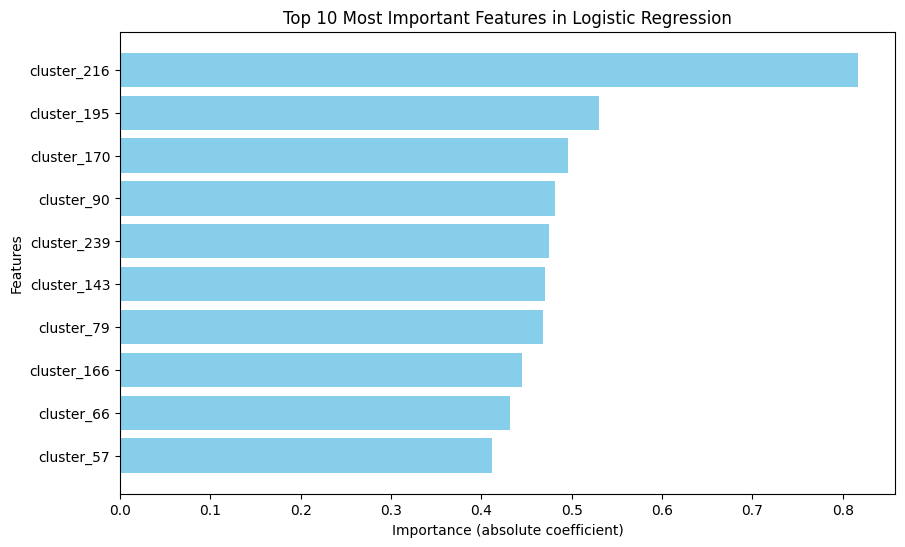

In [40]:
import matplotlib.pyplot as plt

coefficients = logreg.coef_[0]

feature_names = ['cluster_' + str(i) for i in range(num_clusters)]
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

importance = importance.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
top_features = importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance (absolute coefficient)')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features in Logistic Regression')
plt.gca().invert_yaxis()
plt.savefig("./LR_imp_clusters.png", dpi=1000)
plt.show()

In [31]:
cluster_to_words = {}
for k, v in word_to_cluster.items():
    if v not in cluster_to_words:
        cluster_to_words[v] = [k]
    else:
        cluster_to_words[v].append(k)

In [39]:
print( cluster_to_words[216] )

["'s", 'SBP', 'PBC', 'DLBC', 'renal function', 'BS', 'UOP', 'low crit', 'r/o infection', 'TEMP', 'weight change', 'HCT', 'troponin', 'Hct', 's', 'CLBP', 'systolic blood pressure', 'hematocrit', 'exocrine function', 'Hgb', 'urine output', 'respiratory distress,SBP', 'satus', 'WCT', 'bili', 'in hct', 'leuks', 'wt', 'HUN', 'hct', 'SBR', 'in hematocrit', 'prolong QT', 'temp', "UTI's", 'HBP', 'low b12', 'renal fxn', 'bs', 'low platelets', 'lung capacity', 'BK']


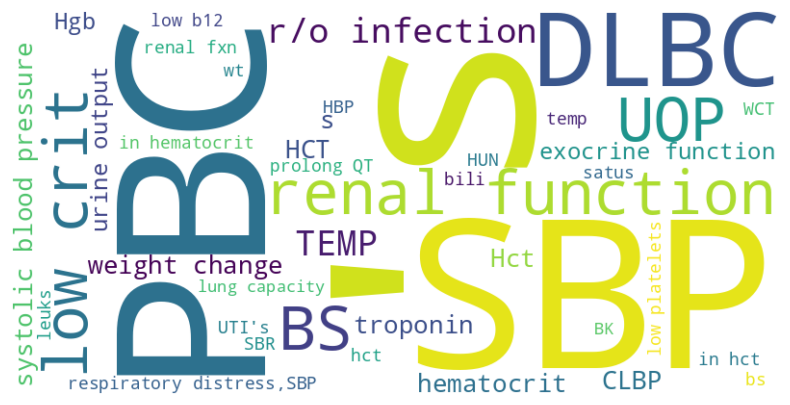

In [ ]:
words = ["'s", 'SBP', 'PBC', 'DLBC', 'renal function', 'BS', 'UOP', 'low crit', 'r/o infection', 'TEMP', 'weight change', 'HCT', 'troponin', 'Hct', 's', 'CLBP', 'systolic blood pressure', 'hematocrit', 'exocrine function', 'Hgb', 'urine output', 'respiratory distress,SBP', 'satus', 'WCT', 'bili', 'in hct', 'leuks', 'wt', 'HUN', 'hct', 'SBR', 'in hematocrit', 'prolong QT', 'temp', "UTI's", 'HBP', 'low b12', 'renal fxn', 'bs', 'low platelets', 'lung capacity', 'BK']

d = { word : 1 for word in words }
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(d)


from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('./wordcloud_cluster216.png')
plt.show()